<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/neuralnets/denoising_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#How can we improve this model?

import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import numpy as np

# Load and normalize MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)  # Expand dimensions to add channel
x_test = np.expand_dims(x_test, -1)

# Add Gaussian noise to a portion of the dataset
noise_factor = 0.5
num_noisy_samples = int(0.5 * x_train.shape[0])  # Make 50% of the training set noisy
x_train_noisy = x_train[:num_noisy_samples] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train[:num_noisy_samples].shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

# Create a mixed dataset with both noisy and clear images
x_train_mixed = np.concatenate((x_train_noisy, x_train[num_noisy_samples:]), axis=0)
y_train_mixed = np.concatenate((y_train[:num_noisy_samples], y_train[num_noisy_samples:]), axis=0)

# Build the multi-task model
input_img = Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Classification Branch
flatten = layers.Flatten()(encoded)
classifier_output = layers.Dense(10, activation='softmax', name='classification')(flatten)

# Denoising Branch
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='denoising')(x)

# Define the model
multi_task_model = models.Model(inputs=input_img, outputs=[classifier_output, decoder_output])

# Compile the model with multiple loss functions for each task
multi_task_model.compile(optimizer='adam',
                         loss={'classification': 'sparse_categorical_crossentropy', 'denoising': 'mse'},
                         loss_weights={'classification': 1.0, 'denoising': 1.0},
                         metrics={'classification': 'accuracy'})

# Train the model
multi_task_model.fit(x_train_mixed,
                     {'classification': y_train_mixed, 'denoising': x_train_mixed},
                     epochs=5,
                     batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 239ms/step - classification_accuracy: 0.7040 - classification_loss: 0.9869 - denoising_loss: 0.0806 - loss: 1.0675
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 233ms/step - classification_accuracy: 0.9336 - classification_loss: 0.2169 - denoising_loss: 0.0436 - loss: 0.2604
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - classification_accuracy: 0.9526 - classification_loss: 0.1558 - denoising_loss: 0.0417 - loss: 0.1975
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 254ms/step - classification_accuracy: 0.9596 - classification_loss: 0.1309 - denoising_loss: 0.0409 - loss: 0.1718
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 245ms/step - classification_accuracy: 0.9637 - classification_loss: 0.1164 - denoising_loss: 0.0404 - loss: 0.1568


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - classification_accuracy: 0.9351 - classification_loss: 0.2003 - denoising_loss: 0.0492 - loss: 0.2495
Test Classification Accuracy: 0.9455
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


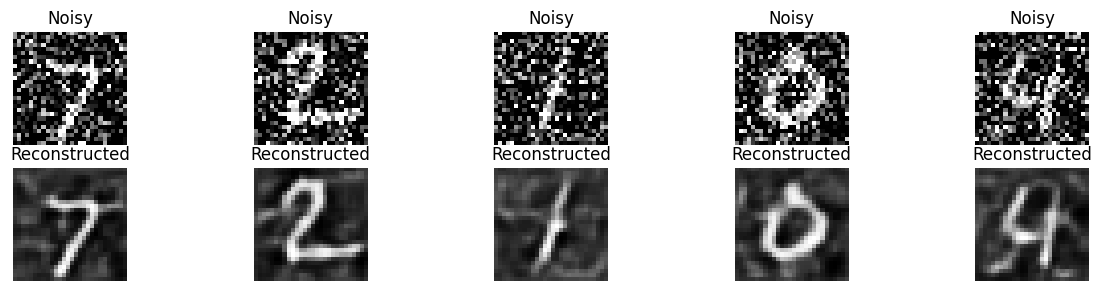

In [2]:
# Add noise to the entire test dataset for evaluation purposes
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Evaluate the classification accuracy
test_loss, test_class_loss, test_denoise_loss, test_acc = multi_task_model.evaluate(x_test_noisy, {'classification': y_test, 'denoising': x_test})
print(f'Test Classification Accuracy: {test_acc:.4f}')

# Use the trained model to reconstruct noisy images
reconstructed_imgs = multi_task_model.predict(x_test_noisy)[1]

# Plot a few examples of noisy and reconstructed images
n = 5  # Number of images to display
plt.figure(figsize=(15, 5))

for i in range(n):
    # Display noisy image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Display reconstructed image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
